In [1]:
import pandas as pd
import numpy as np
import os
import sys
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Dict, List, Optional, Set, Union
import unicodedata

# Configure pandas to display all columns
pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.entities.lineup import Lineup, Player, Position

from src.db.nst_db_utils import *
from src.db.nhl_db_utils import get_player_full_name
from src.data_processing.nst_scraper import *
from src.data_processing.pbp_utils import *
from src.data_processing.game_utils import *
from src.data_processing.team_utils import *
from src.data_processing.player_utils import *

In [2]:
goalie_stats = get_goalie_stats(
    start_date="2024-10-01",
    end_date="2025-01-31",
    table_name="goalie_stats_5v5"
)

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.


In [3]:
goalie_stats

,date,player,team,toi,shots_against,saves,goals_against,sv_pct,gaa,gsaa,xg_against,hd_shots_against,hd_saves,hd_goals_against,hdsv_pct,md_shots_against,md_saves,md_goals_against,mdsv_pct,ld_shots_against,ld_saves,ld_goals_against,ldsv_pct,rush_attempts_against,rebound_attempts_against,avg_shot_distance,avg_goal_distance
0,2025-01-31,Daniil Tarasov,CBJ,50.23,24,23,1,0.958,1.19,1.52,2.66,5,4,1,0.8,3,3,0,1.0,16,16,0,1.0,1,8,37.92,10.0
1,2025-01-31,Thatcher Demko,VAN,46.75,12,10,2,0.833,2.57,-0.74,1.54,5,3,2,0.6,2,2,0,1.0,5,5,0,1.0,3,3,31.0,11.0
2,2025-01-31,Mackenzie Blackwood,COL,49.57,16,16,0,1.0,0.0,1.68,1.35,3,3,0,1.0,6,6,0,1.0,7,7,0,1.0,4,2,31.81,NaN
3,2025-01-31,Karel Vejmelka,UTA,50.23,16,14,2,0.875,2.39,-0.32,0.96,2,1,1,0.5,2,2,0,1.0,11,10,1,0.909,0,2,42.13,21.0
4,2025-01-31,Jake Oettinger,DAL,46.75,17,15,2,0.882,2.57,-0.22,1.39,4,3,1,0.75,0,0,0,NaN,11,10,1,0.909,1,2,51.24,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,2024-10-08,Petr Mrazek,CHI,50.7,24,20,4,0.833,4.73,-1.15,2.57,9,7,2,0.778,8,7,1,0.875,6,5,1,0.833,1,6,33.29,26.25
1726,2024-10-05,Devon Levi,BUF,45.43,26,24,2,0.923,2.64,-0.14,2.54,6,4,2,0.667,7,7,0,1.0,12,12,0,1.0,3,6,31.0,11.0
1727,2024-10-05,Jake Allen,NJD,45.43,16,15,1,0.938,1.32,0.14,1.39,3,2,1,0.667,1,1,0,1.0,11,11,0,1.0,1,4,46.19,7.0
1728,2024-10-04,Jacob Markstrom,NJD,46.72,26,25,1,0.962,1.28,1.31,2.59,5,4,1,0.8,5,5,0,1.0,15,15,0,1.0,3,7,41.46,16.0


In [4]:
db_prefix = 'NHL_DB_'

def extract_team_goalies(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.
    
    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.
    
    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id, back_to_back = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbreviations to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    elif team.upper() == 'UTA':
        # Since UTA did not exist in the previous season, match with ARI
        if 'ARI' == away_team_code.upper():
            team_side = 'Away'
            skaters = away_skaters
            goalies = away_goalies
        elif 'ARI' == home_team_code.upper():
            team_side = 'Home'
            skaters = home_skaters
            goalies = home_goalies
        else:
            raise ValueError(f"Team '{team}' not found in game ID {game_id}.")
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")
    print(f"Back to back: {back_to_back}")
    lineup.back_to_back = back_to_back  # Assign back_to_back to the Lineup

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
# col_lineup = extract_team_lineup('COL', '2024-12-10')

In [5]:
def get_pregame_matchup_stats(input_date: str, team: str, last_n: int=None, team_stats_df: pd.DataFrame=None) -> Dict[str, Any]:
    """
    Retrieves and compiles pre-game statistics for both teams in a matchup.
    
    This function performs the following steps:
    1. Calculates reference date and retrieves team statistics
    2. Identifies the matchup game and opponent team
    3. Compiles team-level statistics for both teams
    4. Identifies starting goalies for both teams
    
    Args:
        input_date (str): The game date in 'YYYY-MM-DD' format
        team (str): The three-letter team code (e.g., 'TOR')
        last_n (int, optional): Number of previous games to consider for team statistics
        team_stats_df (pd.DataFrame, optional): Pre-loaded team statistics DataFrame. If None, will fetch new data
    
    Returns:
        pd.DataFrame: A DataFrame with two rows (one per team) containing:
            - Game context (date, game_id, home/away)
            - Team statistics
            - Starting goalie information (name, team, id)
    """
    try:
        # Step 1a: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 1b: If team_stats_df is not provided, fetch them
        if team_stats_df is None or team_stats_df.empty:
            team_stats_df = nst_team_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                stype=2,
                sit='all',
                last_n=last_n
            )

        # Step 3: Retrieve matchup games for the input date
        print(f"Retrieving matchup games for date {input_date}.")
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        # Initialize variables
        game_id = None
        opponent_team_tricode = None
        side = None

        # Step 4: Identify the game_id involving the specified team
        for gid, gdate in zip(game_ids, game_dates):
            print(f"Checking Game ID: {gid} on Date: {gdate}")
            boxscore = get_game_boxscore(gid, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            print(f"Away Team: {away_team}, Home Team: {home_team}")
            
            if team.upper() == away_team.upper():
                opponent_team_tricode = home_team.upper()
                game_id = gid
                side = 'A'
                print(f"Team {team} found as Away Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                break
            elif team.upper() == home_team.upper():
                opponent_team_tricode = away_team.upper()
                game_id = gid
                side = 'H'
                print(f"Team {team} found as Home Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                break

        if not game_id or not opponent_team_tricode:
            raise ValueError(f"Team {team} did not play on {input_date} or could not determine opponent.")
        
        # Step 5: Get full names for both teams
        team_fullname = get_fullname_by_tricode(team)
        opponent_team_fullname = get_fullname_by_tricode(opponent_team_tricode)

        if team_fullname is None or opponent_team_fullname is None:
            raise ValueError(f"Could not find full names for teams: {team} or {opponent_team_tricode}")
        
        # Remove accent marks and punctuation from both team names
        team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
        )
        opponent_team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', opponent_team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
        )
        
        # Create matchup DataFrame - Modified section
        if 'team' not in team_stats_df.columns:
            raise KeyError("Column 'team' not found in team_stats_df. Please verify the scraped data.")

        # Filter stats for both teams
        team_row = team_stats_df[team_stats_df['team'].str.lower() == team_fullname.lower()]
        opponent_row = team_stats_df[team_stats_df['team'].str.lower() == opponent_team_fullname.lower()]
        
        if team_row.empty or opponent_row.empty:
            raise ValueError(f"Could not find statistics for one or both teams")
            
        # Create a new DataFrame with team names but opponent stats
        matchup_df = pd.DataFrame()
        
        # First row: Keep team name but use opponent's stats
        first_row = opponent_row.copy()
        first_row['team'] = team
        
        # Second row: Keep opponent name but use team's stats
        second_row = team_row.copy()
        second_row['team'] = opponent_team_tricode
        
        # Combine rows
        matchup_df = pd.concat([first_row, second_row])
        
        # Add additional context columns
        matchup_df['home'] = [side == 'H', side == 'A']
        matchup_df['game_id'] = game_id
        matchup_df['game_date'] = input_date

        # Convert team names to tricodes
        matchup_df['team'] = [team, opponent_team_tricode]

        # Drop specified columns
        columns_to_drop = ['gp', 'toi', 'w', 'l', 'otl', 'row', 'points', 'point_%']
        matchup_df = matchup_df.drop(columns=columns_to_drop, errors='ignore')

        # Reorder columns to put game_date and game_id first
        cols = matchup_df.columns.tolist()
        cols = ['game_date', 'game_id', 'home'] + [col for col in cols if col not in ['game_date', 'game_id', 'home']]
        matchup_df = matchup_df[cols]
        
        # Reset index
        matchup_df = matchup_df.reset_index(drop=True)
    
        # Get goalie information for both teams
        goalie_info = []
        for idx, row in matchup_df.iterrows():
            try:
                # If the game is in the past, just read the goalie from the boxscore
                if input_date < datetime.now().strftime('%Y-%m-%d'):
                    boxscore = get_game_boxscore(row['game_id'], clean=False)
                    # Use awayTeam for first row (idx=0), homeTeam for second row (idx=1)
                    team_type = 'awayTeam' if idx == 0 else 'homeTeam'
                    goalies = boxscore['playerByGameStats'][team_type]['goalies']
                    
                    if goalies:
                        # Sort goalies by TOI (descending) and take the one with most ice time
                        starting_goalie = max(goalies, key=lambda x: x.get('toi', '00:00'))
                        if starting_goalie.get('toi') != '00:00':
                            goalie_info.append({
                                'goalie_name': get_player_full_name(starting_goalie.get('playerId'), 'NHL_DB_', suppress_log=True),
                                'goalie_team': row['team'],
                                'goalie_id': starting_goalie.get('playerId')
                            })
                        else:
                            goalie_info.append({
                                'goalie_name': None,
                                'goalie_team': None,
                                'goalie_id': None
                            })
                    else:
                        goalie_info.append({
                            'goalie_name': None,
                            'goalie_team': None,
                            'goalie_id': None
                        })
                else:
                    lineup = extract_team_goalies(row['team'], input_date)
                    if lineup.goalies[0] is not None:  # Get starting goalie
                        goalie = lineup.goalies[0]
                        goalie_info.append({
                            'goalie_name': goalie.name,
                            'goalie_team': goalie.team,
                            'goalie_id': goalie.player_id
                        })
                    else:
                        goalie_info.append({
                            'goalie_name': None,
                            'goalie_team': None,
                            'goalie_id': None
                        })
            except Exception as e:
                print(f"Error getting goalie for {row['team']}: {e}")
                goalie_info.append({
                    'goalie_name': None,
                    'goalie_team': None,
                    'goalie_id': None
                })
        
        # Add goalie information to matchup_df
        for col in ['goalie_name', 'goalie_team', 'goalie_id']:
            matchup_df[col] = [info[col] for info in goalie_info]
        
        # Reset index
        matchup_df = matchup_df.reset_index(drop=True)
        
        return matchup_df

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        return None

# # Example usage of the process_team_and_opponent function
# input_date = '2024-10-04'
# team = 'WPG'  # Example team code
# matchup_data = get_pregame_matchup_stats(input_date, team, last_n=14)

In [6]:
# matchup_data

In [7]:
def calculate_goalie_rolling_stats(df, player_name: str, window_size: int = 10, date: str = None):
    """Create rolling averages and statistics for a specific goalie
    
    Args:
        df (pd.DataFrame): Input dataframe with goalie statistics
        player_name (str): Name of the player to process
        window_size (int, optional): Size of rolling window for statistics. Defaults to 10.
        date (str, optional): If provided, filter out data on or after this date
        
    Returns:
        pd.DataFrame: Processed statistics for the specified player or league averages if player not found
    """
    # Make a copy and filter for specific player
    player_df = df[df['player'] == player_name].copy()
    
    # If no data found for player, use league averages
    if player_df.empty:
        print(f"No data found for player: {player_name}. Using league averages.")
        
        # Calculate league averages
        league_df = df.copy()
        league_df['date'] = pd.to_datetime(league_df['date'])
        
        if date:
            cutoff_date = pd.to_datetime(date)
            league_df = league_df[league_df['date'] < cutoff_date]
        
        # Convert numeric columns from object to float
        numeric_cols = ['sv_pct', 'gaa', 'gsaa', 'xg_against', 'hdsv_pct', 
                       'mdsv_pct', 'ldsv_pct', 'avg_shot_distance', 'avg_goal_distance']
        for col in numeric_cols:
            league_df[col] = pd.to_numeric(league_df[col], errors='coerce')
        
        # Calculate league averages for all relevant columns
        feature_columns = [
            'shots_against', 'sv_pct', 'gaa', 'gsaa',
            'xg_against', 
            'hd_shots_against', 'hdsv_pct',
            'md_shots_against', 'mdsv_pct',
            'ld_shots_against', 'ldsv_pct'
        ]
        
        # Create a single row DataFrame with league averages
        league_averages = pd.DataFrame([{
            f'{col}_rolling_avg': league_df[col].mean() for col in feature_columns
        }])
        
        # Add standard deviations
        for col in feature_columns:
            league_averages[f'{col}_rolling_std'] = league_df[col].std()
        
        # Add workload features (use median values)
        league_averages['days_rest'] = 3.0  # typical rest between games
        league_averages['games_last_7'] = 2.0  # typical games in 7 days
        
        return league_averages
    
    # If we have player data, proceed with normal calculations
    player_df['date'] = pd.to_datetime(player_df['date'])
    player_df = player_df.sort_values('date')
    
    # Convert numeric columns from object to float
    numeric_cols = ['sv_pct', 'gaa', 'gsaa', 'xg_against', 'hdsv_pct', 
                   'mdsv_pct', 'ldsv_pct', 'avg_shot_distance', 'avg_goal_distance']
    for col in numeric_cols:
        player_df[col] = pd.to_numeric(player_df[col], errors='coerce')
    
    feature_columns = [
        'shots_against', 'sv_pct', 'gaa', 'gsaa',
        'xg_against', 
        'hd_shots_against', 'hdsv_pct',
        'md_shots_against', 'mdsv_pct',
        'ld_shots_against', 'ldsv_pct'
    ]
    
    try:
        print(f"Processing player: {player_name}")
        print(f"Data shape: {player_df.shape}")
        
        # Calculate rolling statistics
        for col in feature_columns:
            player_df[f'{col}_rolling_avg'] = player_df[col].rolling(
                window=window_size, min_periods=1
            ).mean()
            player_df[f'{col}_rolling_std'] = player_df[col].rolling(
                window=window_size, min_periods=1
            ).std()
        
        # Add workload features
        player_df['days_rest'] = player_df['date'].diff().dt.days
        player_df['games_last_7'] = player_df.rolling('7D', on='date')['date'].count()
        
        print(f"Successfully processed {player_name}")
        
        # Filter out dates if date is provided
        if date:
            cutoff_date = pd.to_datetime(date)
            player_df = player_df[player_df['date'] < cutoff_date]
            if player_df.empty:
                print(f"No data found for {player_name} before {date}. Using league averages.")
                return calculate_goalie_rolling_stats(df, player_name, window_size)  # Recursive call without date
            player_df = player_df.tail(1).reset_index(drop=True)

        # Keep only date, rolling features, and workload features
        rolling_cols = [col for col in player_df.columns if 'rolling' in col]
        cols_to_keep = ['date', 'player', 'team'] + rolling_cols + ['days_rest', 'games_last_7']
        player_df = player_df[cols_to_keep]
            
        return player_df
        
    except Exception as e:
        print(f"Error processing player {player_name}: {str(e)}")
        print("Data types:", player_df.dtypes)
        raise

In [8]:
def enrich_matchup_with_goalie_stats(
    matchup_df: pd.DataFrame,
    goalie_stats_df: pd.DataFrame,
    window_size: int = 10
) -> pd.DataFrame:
    """
    Enriches matchup data with rolling goalie statistics.
    
    Args:
        matchup_df (pd.DataFrame): Output from get_pregame_matchup_stats
        goalie_stats_df (pd.DataFrame): Raw goalie statistics
        window_size (int): Window size for rolling calculations
        
    Returns:
        pd.DataFrame: Enhanced matchup data with goalie rolling statistics
    """
    # Create a copy to avoid modifying original
    enriched_df = matchup_df.copy()
    
    # Process each goalie in the matchup
    for idx, row in enriched_df.iterrows():
        if pd.isna(row['goalie_name']):
            continue
            
        try:
            # Calculate rolling stats for this goalie
            goalie_rolling_stats = calculate_goalie_rolling_stats(
                goalie_stats_df,
                player_name=row['goalie_name'],
                window_size=window_size,
                date=row['game_date']
            )
            
            if not goalie_rolling_stats.empty:
                # Add prefix to rolling columns to avoid confusion with team stats
                rolling_cols = [col for col in goalie_rolling_stats.columns 
                              if col not in ['date', 'player', 'team']]
                
                for col in rolling_cols:
                    enriched_df.at[idx, f'g_{col}'] = goalie_rolling_stats.iloc[0][col]
                    
        except Exception as e:
            print(f"Error processing goalie {row['goalie_name']}: {e}")
            # Continue with next goalie if one fails
            continue
    
    return enriched_df

# matchup_data = enrich_matchup_with_goalie_stats(matchup_data, goalie_stats)

In [9]:
def get_matchup_goalie_results(matchup_df: pd.DataFrame) -> pd.DataFrame:
    """
    Retrieves actual game results for goalies from a matchup DataFrame.
    
    Args:
        matchup_df (pd.DataFrame): DataFrame containing matchup data with game_id column
        
    Returns:
        pd.DataFrame: Original matchup data with additional columns for actual game results
    """
    # Get the boxscore data
    game_id = matchup_df['game_id'].iloc[0]
    game_data = get_game_boxscore(game_id, clean=False)
    player_stats = game_data.get('playerByGameStats', {})
    
    # Create a copy of the input DataFrame
    enriched_df = matchup_df.copy()
    
    # Process each team's data
    for idx, row in enriched_df.iterrows():
        team_type = 'homeTeam' if row['home'] else 'awayTeam'
        goalies = player_stats.get(team_type, {}).get('goalies', [])
        
        if goalies:
            # Find the goalie whose name matches the one in enriched_df
            matching_goalie = None
            for g in goalies:
                goalie_name = get_player_full_name(g.get('playerId'), 'NHL_DB_', suppress_log=True)
                if goalie_name == row['goalie_name']:
                    matching_goalie = g
                    break
            
            # If no matching goalie found, use the first one (as before)
            goalie = matching_goalie or goalies[0]
            
            shots = goalie.get('shotsAgainst', 0)
            saves = goalie.get('saves', 0)
            
            enriched_df.loc[idx, 'res_saves'] = saves
            enriched_df.loc[idx, 'res_shots_against'] = shots
            enriched_df.loc[idx, 'res_save_pct'] = round(saves / shots if shots > 0 else 0.0, 3)
            enriched_df.loc[idx, 'res_goals_against'] = goalie.get('goalsAgainst', 0)
            enriched_df.loc[idx, 'res_decision'] = goalie.get('decision', 'N/A')
    
    return enriched_df

In [10]:
def process_matchups_for_date(input_date: str, last_n: int = None) -> pd.DataFrame:
    """
    Processes all matchup games for a given date by getting matchup stats, 
    enriching with goalie stats, and getting actual game results.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format
        last_n (int, optional): Number of last games to consider for stats
    
    Returns:
        pd.DataFrame: A DataFrame containing all matchups for the date with 
                     pre-game stats and actual results
    """
    try:
        # Step 1: Get matchup games for the date
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        
        if not game_ids:
            print(f"No games found for the date {input_date}.")
            return pd.DataFrame()

        # Step 2: Get goalie stats for enrichment
        goalie_stats = get_goalie_stats(
            end_date=input_date,
            table_name="goalie_stats_5v5"
        )

        # Get team stats for matchup date so they are not scraped each time
        team_stats_df = nst_team_on_ice_scraper(
            startdate='',
            enddate=input_date,
            stype=2,
            sit='all',
            last_n=last_n
        )

        results = []
        
        # Step 3: Process each game
        for game_id in game_ids:
            print(f"\nProcessing Game ID: {game_id}")
            
            # Get boxscore to determine teams
            boxscore = get_game_boxscore(game_id, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            
            if not away_team or not home_team:
                print(f"Could not extract teams for Game ID: {game_id}. Skipping.")
                continue
                
            # Process away team
            try:
                matchup = get_pregame_matchup_stats(input_date, away_team, last_n=last_n, team_stats_df=team_stats_df)
                matchup = enrich_matchup_with_goalie_stats(matchup, goalie_stats)
                matchup = get_matchup_goalie_results(matchup)
                results.append(matchup)
            except Exception as e:
                print(f"Error processing away team {away_team}: {e}")

        # Combine all results
        if results:
            final_df = pd.concat(results, ignore_index=True)
            print("\nAll matchups processed successfully.")
            return final_df
        else:
            print("No matchups were successfully processed.")
            return pd.DataFrame()

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

In [11]:
# matchups = process_matchups_for_date('2024-12-10', last_n=15)

In [12]:
def process_matchups_for_date_range(start_date: str, end_date: str, last_n: int = None) -> pd.DataFrame:
    """
    Processes matchup games for a range of dates by calling process_matchups_for_date for each date.
    
    Args:
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        last_n (int, optional): Number of last games to consider for stats
    
    Returns:
        pd.DataFrame: A DataFrame containing all matchups for the date range with 
                     pre-game stats and actual results
    """
    try:
        # Convert dates to datetime objects
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        
        # Generate list of dates
        dates = pd.date_range(start=start, end=end, freq='D')
        
        all_results = []
        
        # Process each date
        for date in dates:
            date_str = date.strftime('%Y-%m-%d')
            print(f"\nProcessing date: {date_str}")
            
            # Process matchups for this date
            daily_results = process_matchups_for_date(date_str, last_n=last_n)
            if not daily_results.empty:
                all_results.append(daily_results)

            time.sleep(random.randint(45, 60))
        
        # Combine all results
        if all_results:
            final_df = pd.concat(all_results, ignore_index=True)
            print(f"\nProcessed {len(dates)} days of matchups successfully.")
            return final_df
        else:
            print("No matchups were successfully processed for the date range.")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# Example usage:
matchups_range = process_matchups_for_date_range('2025-02-01', '2025-02-09', last_n=15)


Processing date: 2025-02-01


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2024020826
Fetching data for reference date: 2025-01-31
Retrieving matchup games for date 2025-02-01.
Checking Game ID: 2024020826 on Date: 2025-02-01
Away Team: CHI, Home Team: FLA
Team CHI found as Away Team in Game ID 2024020826. Opponent TriCode: FLA
Processing player: Petr Mrazek
Data shape: (98, 27)
Successfully processed Petr Mrazek
Processing player: Sergei Bobrovsky
Data shape: (105, 27)
Successfully processed Sergei Bobrovsky

Processing Game ID: 2024020827
Fetching data for reference date: 2025-01-31
Retrieving matchup games for date 2025-02-01.
Checking Game ID: 2024020826 on Date: 2025-02-01
Away Team: CHI, Home Team: FLA
Checking Game ID: 2024020827 on Date: 2025-02-01
Away Team: NYR, Home Team: BOS
Team NYR found as Away Team in Game ID 2024020827. Opponent TriCode: BOS
Processing player: Igor Shesterkin
Data shape: (106, 27)
Successfully processed Igor Shesterkin
Processing player: Jeremy Swayman
Data shape: (94, 27)
Successfully processed Jeremy Sw

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2024020835
Fetching data for reference date: 2025-02-01
Retrieving matchup games for date 2025-02-02.
Checking Game ID: 2024020835 on Date: 2025-02-02
Away Team: NJD, Home Team: BUF
Team NJD found as Away Team in Game ID 2024020835. Opponent TriCode: BUF
Processing player: Jake Allen
Data shape: (56, 27)
Successfully processed Jake Allen
Processing player: Ukko-Pekka Luukkonen
Data shape: (96, 27)
Successfully processed Ukko-Pekka Luukkonen

Processing Game ID: 2024020836
Fetching data for reference date: 2025-02-01
Retrieving matchup games for date 2025-02-02.
Checking Game ID: 2024020835 on Date: 2025-02-02
Away Team: NJD, Home Team: BUF
Checking Game ID: 2024020836 on Date: 2025-02-02
Away Team: PHI, Home Team: COL
Team PHI found as Away Team in Game ID 2024020836. Opponent TriCode: COL
Processing player: Samuel Ersson
Data shape: (71, 27)
Successfully processed Samuel Ersson
Processing player: Mackenzie Blackwood
Data shape: (84, 27)
Successfully processed Mack

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2024020844
Fetching data for reference date: 2025-02-02
Retrieving matchup games for date 2025-02-03.
Checking Game ID: 2024020844 on Date: 2025-02-03
Away Team: OTT, Home Team: NSH
Team OTT found as Away Team in Game ID 2024020844. Opponent TriCode: NSH
Processing player: Anton Forsberg
Data shape: (52, 27)
Successfully processed Anton Forsberg
Processing player: Juuse Saros
Data shape: (124, 27)
Successfully processed Juuse Saros

All matchups processed successfully.

Processing date: 2025-02-04


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2024020845
Fetching data for reference date: 2025-02-03
Retrieving matchup games for date 2025-02-04.
Checking Game ID: 2024020845 on Date: 2025-02-04
Away Team: MIN, Home Team: BOS
Team MIN found as Away Team in Game ID 2024020845. Opponent TriCode: BOS
Processing player: Marc-Andre Fleury
Data shape: (70, 27)
Successfully processed Marc-Andre Fleury
Processing player: Jeremy Swayman
Data shape: (95, 27)
Successfully processed Jeremy Swayman

Processing Game ID: 2024020846
Fetching data for reference date: 2025-02-03
Retrieving matchup games for date 2025-02-04.
Checking Game ID: 2024020845 on Date: 2025-02-04
Away Team: MIN, Home Team: BOS
Checking Game ID: 2024020846 on Date: 2025-02-04
Away Team: CBJ, Home Team: BUF
Team CBJ found as Away Team in Game ID 2024020846. Opponent TriCode: BUF
Processing player: Elvis Merzlikins
Data shape: (84, 27)
Successfully processed Elvis Merzlikins
Processing player: James Reimer
Data shape: (49, 27)
Successfully processed Jam

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2024020859
Fetching data for reference date: 2025-02-04
Retrieving matchup games for date 2025-02-05.
Checking Game ID: 2024020859 on Date: 2025-02-05
Away Team: BOS, Home Team: NYR
Team BOS found as Away Team in Game ID 2024020859. Opponent TriCode: NYR
Processing player: Joonas Korpisalo
Data shape: (81, 27)
Successfully processed Joonas Korpisalo
Processing player: Igor Shesterkin
Data shape: (107, 27)
Successfully processed Igor Shesterkin

Processing Game ID: 2024020860
Fetching data for reference date: 2025-02-04
Retrieving matchup games for date 2025-02-05.
Checking Game ID: 2024020859 on Date: 2025-02-05
Away Team: BOS, Home Team: NYR
Checking Game ID: 2024020860 on Date: 2025-02-05
Away Team: EDM, Home Team: CHI
Team EDM found as Away Team in Game ID 2024020860. Opponent TriCode: CHI
Processing player: Calvin Pickard
Data shape: (32, 27)
Successfully processed Calvin Pickard
Processing player: Arvid Soderblom
Data shape: (46, 27)
Successfully processed Arv

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2024020862
Fetching data for reference date: 2025-02-05
Retrieving matchup games for date 2025-02-06.
Checking Game ID: 2024020862 on Date: 2025-02-06
Away Team: OTT, Home Team: TBL
Team OTT found as Away Team in Game ID 2024020862. Opponent TriCode: TBL
Processing player: Anton Forsberg
Data shape: (53, 27)
Successfully processed Anton Forsberg
Processing player: Andrei Vasilevskiy
Data shape: (110, 27)
Successfully processed Andrei Vasilevskiy

Processing Game ID: 2024020863
Fetching data for reference date: 2025-02-05
Retrieving matchup games for date 2025-02-06.
Checking Game ID: 2024020862 on Date: 2025-02-06
Away Team: OTT, Home Team: TBL
Checking Game ID: 2024020863 on Date: 2025-02-06
Away Team: VGK, Home Team: NJD
Team VGK found as Away Team in Game ID 2024020863. Opponent TriCode: NJD
Processing player: Adin Hill
Data shape: (73, 27)
Successfully processed Adin Hill
Processing player: Jake Allen
Data shape: (57, 27)
Successfully processed Jake Allen

Proc

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2024020871
Fetching data for reference date: 2025-02-06
Retrieving matchup games for date 2025-02-07.
Checking Game ID: 2024020871 on Date: 2025-02-07
Away Team: PIT, Home Team: NYR
Team PIT found as Away Team in Game ID 2024020871. Opponent TriCode: NYR
Processing player: Alex Nedeljkovic
Data shape: (51, 27)
Successfully processed Alex Nedeljkovic
Processing player: Igor Shesterkin
Data shape: (108, 27)
Successfully processed Igor Shesterkin

Processing Game ID: 2024020872
Fetching data for reference date: 2025-02-06
Retrieving matchup games for date 2025-02-07.
Checking Game ID: 2024020871 on Date: 2025-02-07
Away Team: PIT, Home Team: NYR
Checking Game ID: 2024020872 on Date: 2025-02-07
Away Team: NYI, Home Team: WPG
Team NYI found as Away Team in Game ID 2024020872. Opponent TriCode: WPG
Processing player: Ilya Sorokin
Data shape: (116, 27)
Successfully processed Ilya Sorokin
Processing player: Connor Hellebuyck
Data shape: (121, 27)
Successfully processed Con

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2024020876
Fetching data for reference date: 2025-02-07
Retrieving matchup games for date 2025-02-08.
Checking Game ID: 2024020876 on Date: 2025-02-08
Away Team: NJD, Home Team: MTL
Team NJD found as Away Team in Game ID 2024020876. Opponent TriCode: MTL
Processing player: Jake Allen
Data shape: (58, 27)
Successfully processed Jake Allen
Processing player: Sam Montembeault
Data shape: (97, 27)
Successfully processed Sam Montembeault

Processing Game ID: 2024020877
Fetching data for reference date: 2025-02-07
Retrieving matchup games for date 2025-02-08.
Checking Game ID: 2024020876 on Date: 2025-02-08
Away Team: NJD, Home Team: MTL
Checking Game ID: 2024020877 on Date: 2025-02-08
Away Team: TBL, Home Team: DET
Team TBL found as Away Team in Game ID 2024020877. Opponent TriCode: DET
Processing player: Andrei Vasilevskiy
Data shape: (111, 27)
Successfully processed Andrei Vasilevskiy
Processing player: Cam Talbot
Data shape: (82, 27)
Successfully processed Cam Talbot

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2024020890
Fetching data for reference date: 2025-02-08
Retrieving matchup games for date 2025-02-09.
Checking Game ID: 2024020890 on Date: 2025-02-09
Away Team: UTA, Home Team: WSH
Team UTA found as Away Team in Game ID 2024020890. Opponent TriCode: WSH
Processing player: Karel Vejmelka
Data shape: (84, 27)
Successfully processed Karel Vejmelka
Processing player: Logan Thompson
Data shape: (75, 27)
Successfully processed Logan Thompson

Processing Game ID: 2024020891
Fetching data for reference date: 2025-02-08
Retrieving matchup games for date 2025-02-09.
Checking Game ID: 2024020890 on Date: 2025-02-09
Away Team: UTA, Home Team: WSH
Checking Game ID: 2024020891 on Date: 2025-02-09
Away Team: TBL, Home Team: MTL
Team TBL found as Away Team in Game ID 2024020891. Opponent TriCode: MTL
Processing player: Andrei Vasilevskiy
Data shape: (112, 27)
Successfully processed Andrei Vasilevskiy
Processing player: Sam Montembeault
Data shape: (98, 27)
Successfully processed 

In [13]:
matchups_range.to_csv('../data/g_15_02_25.csv', index=False)

In [28]:
# Get all csv files starting with 'g_15' in data directory
import os

data_dir = '../data'
csv_files = [f for f in os.listdir(data_dir) if f.startswith('g_15') and f.endswith('.csv')]

# Read and combine all matching CSV files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    df['game_date'] = pd.to_datetime(df['game_date'])  # Convert date for sorting
    dfs.append(df)

# Concatenate all dataframes and sort by game_date
processed_df = pd.concat(dfs, ignore_index=True)
processed_df = processed_df.sort_values('game_date').reset_index(drop=True)

In [29]:
processed_df.iloc[:,:-5]

,game_date,game_id,home,team,cf,ca,cf%,ff,fa,ff%,sf,sa,sf%,gf,ga,gf%,xgf,xga,xgf%,scf,sca,scf%,scsf,scsa,scsf%,scgf,scga,scgf%,scsh%,scsv%,hdcf,hdca,hdcf%,hdsf,hdsa,hdsf%,hdgf,hdga,hdgf%,hdsh%,hdsv%,mdcf,mdca,mdcf%,mdsf,mdsa,mdsf%,mdgf,mdga,mdgf%,mdsh%,mdsv%,ldcf,ldca,ldcf%,ldsf,ldsa,ldsf%,ldgf,ldga,ldgf%,ldsh%,ldsv%,sh%,sv%,pdo,b2b,opp_b2b,goalie_name,goalie_team,goalie_id,g_shots_against_rolling_avg,g_shots_against_rolling_std,g_sv_pct_rolling_avg,g_sv_pct_rolling_std,g_gaa_rolling_avg,g_gaa_rolling_std,g_gsaa_rolling_avg,g_gsaa_rolling_std,g_xg_against_rolling_avg,g_xg_against_rolling_std,g_hd_shots_against_rolling_avg,g_hd_shots_against_rolling_std,g_hdsv_pct_rolling_avg,g_hdsv_pct_rolling_std,g_md_shots_against_rolling_avg,g_md_shots_against_rolling_std,g_mdsv_pct_rolling_avg,g_mdsv_pct_rolling_std,g_ld_shots_against_rolling_avg,g_ld_shots_against_rolling_std,g_ldsv_pct_rolling_avg,g_ldsv_pct_rolling_std,g_days_rest,g_games_last_7
0,2024-10-04,2024020001,False,NJD,407,434,48.39,279,324,46.27,189,204,48.09,18,19,48.65,23.23,24.27,48.90,204,209,49.39,98,105,48.28,16,15,51.61,16.33,85.71,61,91,40.13,35,54,39.33,9,8,52.94,25.71,85.19,143,118,54.79,63,51,55.26,7,7,50.00,11.11,86.27,223,271,45.14,81,90,47.37,1,4,20.0,1.23,95.56,9.52,90.69,1.002,0.0,0.0,Jacob Markstrom,NJD,8474593,21.4,3.470511,0.9083,0.047582,2.484,1.233831,-0.107,0.959931,2.055,0.514981,6.1,1.449138,0.820000,0.159349,3.9,1.286684,0.8633,0.168661,10.7,2.540779,0.9715,0.046390,4.0,2.0
1,2024-10-04,2024020001,True,BUF,409,518,44.12,272,381,41.65,180,246,42.25,22,25,46.81,18.32,29.85,38.03,181,254,41.61,93,133,41.15,18,20,47.37,19.35,84.96,71,111,39.01,41,68,37.61,12,11,52.17,29.27,83.82,110,143,43.48,52,65,44.44,6,9,40.00,11.54,86.15,267,317,45.72,80,104,43.48,4,4,50.0,5.00,96.15,12.22,89.84,1.021,0.0,0.0,Ukko-Pekka Luukkonen,BUF,8480045,22.2,7.685484,0.8852,0.133548,4.986,8.208741,-0.364,1.960970,2.105,0.882588,6.2,3.224903,0.830200,0.200812,6.0,4.496913,0.8107,0.300559,8.6,4.221637,0.9690,0.065598,3.0,3.0
2,2024-10-05,2024020002,False,BUF,430,516,45.45,296,366,44.71,197,223,46.90,22,22,50.00,21.29,27.73,43.42,190,244,43.78,103,120,46.19,19,17,52.78,18.45,85.83,77,106,42.08,45,64,41.28,12,9,57.14,26.67,85.94,113,138,45.02,58,56,50.88,7,8,46.67,12.07,85.71,281,314,47.23,86,94,47.78,3,4,42.86,3.49,95.74,11.17,90.13,1.013,1.0,1.0,Devon Levi,BUF,8482221,22.6,4.452215,0.9229,0.062269,2.375,2.064484,0.323,1.302733,2.336,0.785256,6.5,2.798809,0.866400,0.192774,5.9,2.330951,0.9214,0.129107,9.1,3.634709,0.9675,0.054210,2.0,2.0
3,2024-10-05,2024020002,True,NJD,475,497,48.87,321,375,46.12,207,241,46.21,19,22,46.34,25.01,29.03,46.28,225,236,48.81,102,125,44.93,17,18,48.57,16.67,85.60,70,105,40.00,38,63,37.62,10,10,50.00,26.32,84.13,155,131,54.20,64,62,50.79,7,8,46.67,10.94,87.10,266,311,46.10,93,105,46.97,1,4,20.0,1.08,96.19,9.18,90.87,1.001,1.0,1.0,Jake Allen,NJD,8474596,26.4,8.140434,0.8973,0.046337,2.963,0.833227,-0.058,1.075648,2.378,0.890378,6.5,3.807887,0.711400,0.322632,8.1,2.846050,0.8825,0.075276,10.8,5.349974,0.9560,0.056407,3.0,3.0
4,2024-10-08,2024020003,True,SEA,322,389,45.29,237,285,45.40,167,189,46.91,20,16,55.56,15.11,20.72,42.17,139,200,41.00,85,102,45.45,14,14,50.00,16.47,86.27,50,83,37.59,31,56,35.63,6,9,40.00,19.35,83.93,89,117,43.20,54,46,54.00,8,5,61.54,14.81,89.13,198,225,46.81,67,79,45.89,5,2,71.43,7.46,97.47,11.98,91.53,1.035,0.0,0.0,Philipp Grubauer,SEA,8475831,21.7,7.008725,0.8760,0.194889,3.298,4.309952,0.105,1.519212,1.843,0.751355,4.4,3.687818,0.951111,0.102470,5.9,1.791957,0.8617,0.252129,10.4,4.718757,0.8590,0.309036,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,2025-02-08,2024020879,False,VGK,407,

In [30]:
processed_df.columns

Index(['game_date', 'game_id', 'home', 'team', 'cf', 'ca', 'cf%', 'ff', 'fa',
       'ff%', 'sf', 'sa', 'sf%', 'gf', 'ga', 'gf%', 'xgf', 'xga', 'xgf%',
       'scf', 'sca', 'scf%', 'scsf', 'scsa', 'scsf%', 'scgf', 'scga', 'scgf%',
       'scsh%', 'scsv%', 'hdcf', 'hdca', 'hdcf%', 'hdsf', 'hdsa', 'hdsf%',
       'hdgf', 'hdga', 'hdgf%', 'hdsh%', 'hdsv%', 'mdcf', 'mdca', 'mdcf%',
       'mdsf', 'mdsa', 'mdsf%', 'mdgf', 'mdga', 'mdgf%', 'mdsh%', 'mdsv%',
       'ldcf', 'ldca', 'ldcf%', 'ldsf', 'ldsa', 'ldsf%', 'ldgf', 'ldga',
       'ldgf%', 'ldsh%', 'ldsv%', 'sh%', 'sv%', 'pdo', 'b2b', 'opp_b2b',
       'goalie_name', 'goalie_team', 'goalie_id',
       'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
       'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std', 'g_gaa_rolling_avg',
       'g_gaa_rolling_std', 'g_gsaa_rolling_avg', 'g_gsaa_rolling_std',
       'g_xg_against_rolling_avg', 'g_xg_against_rolling_std',
       'g_hd_shots_against_rolling_avg', 'g_hd_shots_against_rolling

In [48]:
"""Train the model on historical goalie data and return evaluation metrics"""
# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Define features to use for model
features = [
    'home','b2b', 'opp_b2b',
    'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'ff%', 'cf%', 'pdo','g_games_last_7'
]

# Instead of random split, use time-based split
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = processed_df[train_mask][features]
X_test = processed_df[test_mask][features]
y_train = processed_df[train_mask]['res_saves']
y_test = processed_df[test_mask]['res_saves']

print(f"Training data from {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing data from {X_test.index.min()} to {X_test.index.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'feature_importance': dict(zip(features, rf_model.feature_importances_))  # Remove .columns
}

Training data from 0 to 1333
Testing data from 1334 to 1779


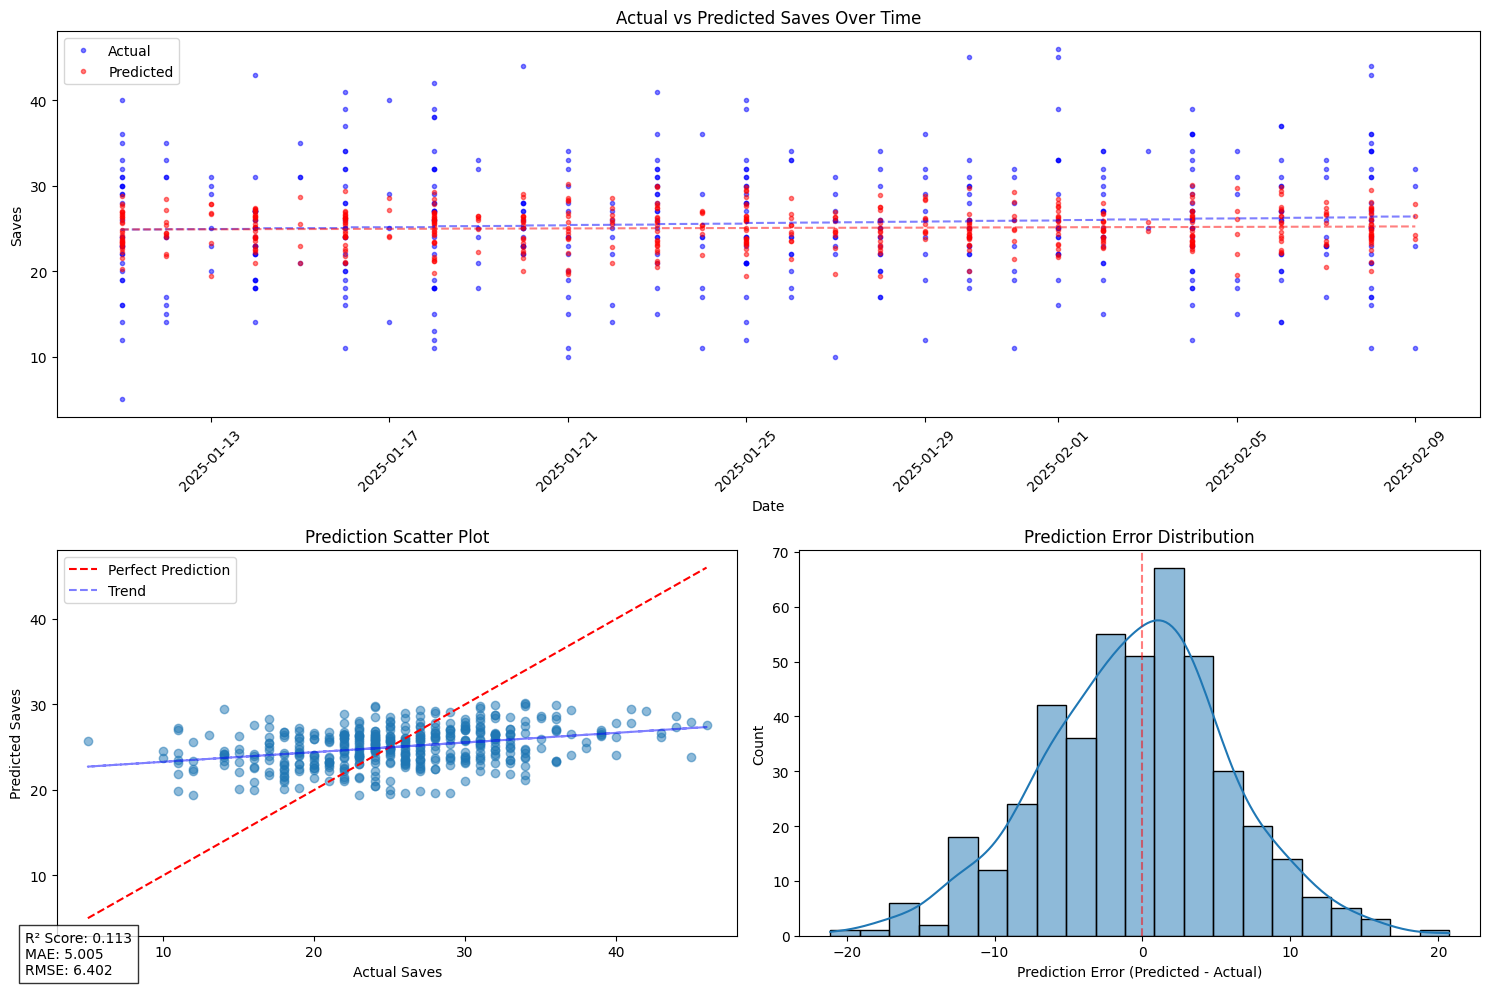


Error Statistics:
Mean Error: -0.534
Error Std Dev: 6.386
Error Range: [-21.103, 20.727]


In [49]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Time series plot (improved version)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(processed_df[test_mask]['game_date'], y_test, 'b.', label='Actual', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], y_pred, 'r.', label='Predicted', alpha=0.5)
# Add trend lines
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_test)), y_test, 1))(range(len(y_test))), 
         'b--', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_pred)), y_pred, 1))(range(len(y_pred))), 
         'r--', alpha=0.5)
ax1.set_title('Actual vs Predicted Saves Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Saves')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Scatter plot with regression line
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test, p(y_test), "b--", alpha=0.5, label='Trend')
ax2.set_xlabel('Actual Saves')
ax2.set_ylabel('Predicted Saves')
ax2.set_title('Prediction Scatter Plot')
ax2.legend()

# 3. Error distribution
ax3 = fig.add_subplot(gs[1, 1])
errors = y_pred - y_test
sns.histplot(errors, kde=True, ax=ax3)
ax3.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax3.set_title('Prediction Error Distribution')
ax3.set_xlabel('Prediction Error (Predicted - Actual)')
ax3.set_ylabel('Count')

# Add metrics text box
metrics_text = f'R² Score: {metrics["r2_score"]:.3f}\nMAE: {metrics["mae"]:.3f}\nRMSE: {metrics["rmse"]:.3f}'
fig.text(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional statistical information
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.3f}")
print(f"Error Std Dev: {errors.std():.3f}")
print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")

Split completed:
R² Score: -0.0146
MAE: 5.4919
RMSE: 6.9992
Time: 0.14 seconds

Split completed:
R² Score: -0.0199
MAE: 5.0373
RMSE: 6.4698
Time: 0.13 seconds

Split completed:
R² Score: 0.0124
MAE: 5.0893
RMSE: 6.3447
Time: 0.12 seconds

Split completed:
R² Score: 0.0984
MAE: 5.1414
RMSE: 6.3390
Time: 0.13 seconds

Split completed:
R² Score: 0.0807
MAE: 4.8811
RMSE: 6.3057
Time: 0.14 seconds


Overall Execution:
Average R² Score: 0.0314
Average MAE: 5.1282
Average RMSE: 6.4917
Average Split Time: 0.13 seconds
Total Execution Time: 0.66 seconds

Top 10 Most Important Features:
                        feature  importance
14                         xgf%    0.099498
12                         scf%    0.097177
13                        hdcf%    0.082203
9   g_shots_against_rolling_std    0.078405
7      g_xg_against_rolling_avg    0.069297
8   g_shots_against_rolling_avg    0.068843
1          g_sv_pct_rolling_std    0.066106
2            g_gsaa_rolling_avg    0.065333
4        g_hdsv_pct_

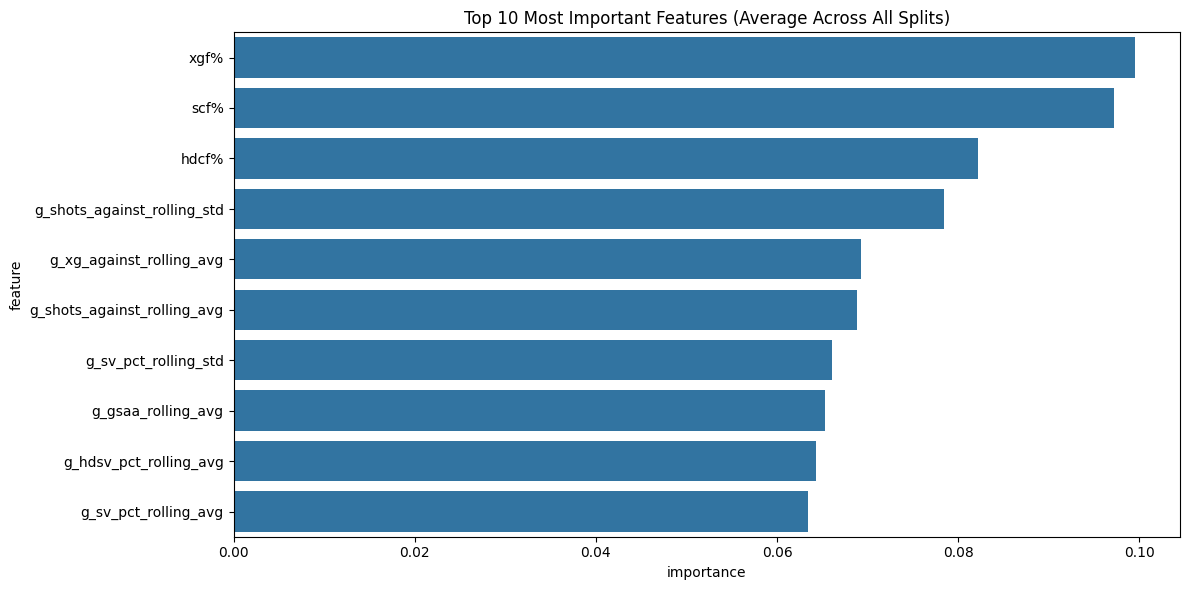

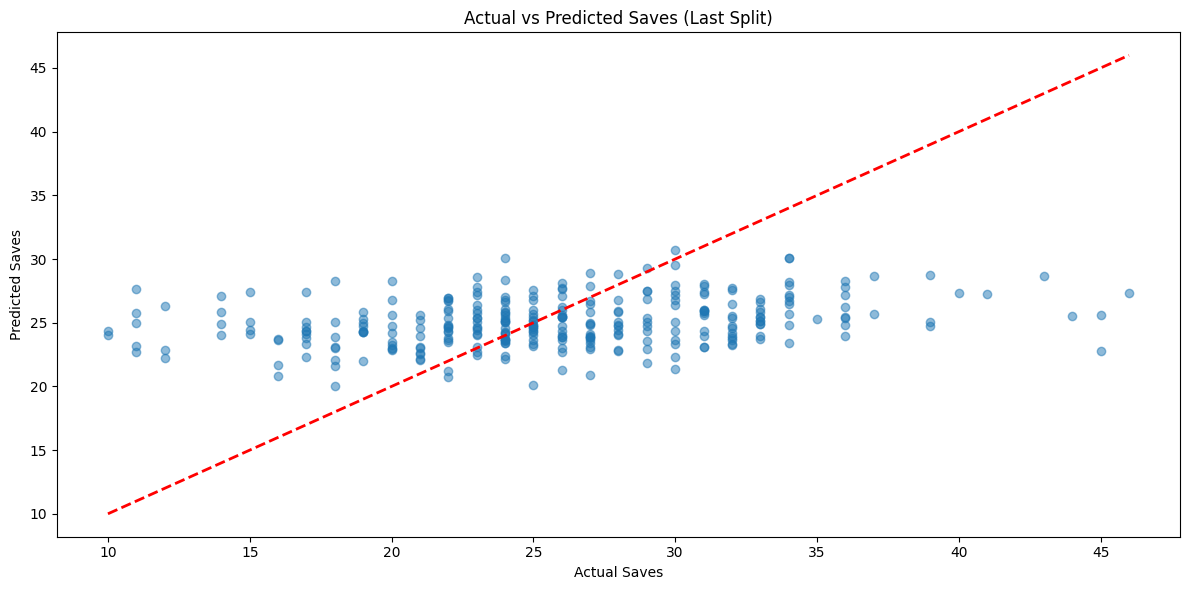

In [33]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Start timing
start_time = time.time()

# Define features grouped by category
goalie_performance_features = [
    'g_sv_pct_rolling_avg',
    'g_sv_pct_rolling_std',  # Consistency metric
    'g_gsaa_rolling_avg',    # Goals saved above average
    'g_gaa_rolling_avg',     # Goals against average
]

shot_quality_features = [
    'g_hdsv_pct_rolling_avg',  # High-danger save percentage
    'g_mdsv_pct_rolling_avg',  # Medium-danger save percentage
    'g_ldsv_pct_rolling_avg',  # Low-danger save percentage
    'g_xg_against_rolling_avg' # Expected goals against
]

workload_features = [
    'g_shots_against_rolling_avg',
    'g_shots_against_rolling_std',
    'g_days_rest',
    'g_games_last_7'
]

team_context_features = [
    'scf%',      # Scoring chances for percentage
    'hdcf%',     # High-danger chances for percentage
    'xgf%',      # Expected goals for percentage
    'home'       # Boolean for home/away
]

# Combine all features
features = (
    goalie_performance_features + 
    shot_quality_features + 
    workload_features + 
    team_context_features
)

# Use TimeSeriesSplit instead of a single date split
tscv = TimeSeriesSplit(n_splits=5)

# Initialize metrics storage
cv_scores = []
execution_times = []
feature_importances = []

for train_idx, test_idx in tscv.split(processed_df):
    split_start_time = time.time()
    
    # Get train/test sets
    X_train = processed_df.iloc[train_idx][features]
    X_test = processed_df.iloc[test_idx][features]
    y_train = processed_df.iloc[train_idx]['res_saves']
    y_test = processed_df.iloc[test_idx]['res_saves']
    
    # Handle missing values and scale
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train and predict
    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    
    rf_model.fit(X_train_scaled, y_train)
    y_pred = rf_model.predict(X_test_scaled)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    cv_scores.append({
        'r2': r2,
        'mae': mae,
        'rmse': rmse
    })
    
    # Store feature importance
    feature_importances.append(rf_model.feature_importances_)
    
    # Record split execution time
    split_time = time.time() - split_start_time
    execution_times.append(split_time)
    
    print(f"Split completed:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Time: {split_time:.2f} seconds\n")

# Calculate and print overall metrics
total_time = time.time() - start_time
print(f"\nOverall Execution:")
print(f"Average R² Score: {np.mean([s['r2'] for s in cv_scores]):.4f}")
print(f"Average MAE: {np.mean([s['mae'] for s in cv_scores]):.4f}")
print(f"Average RMSE: {np.mean([s['rmse'] for s in cv_scores]):.4f}")
print(f"Average Split Time: {np.mean(execution_times):.2f} seconds")
print(f"Total Execution Time: {total_time:.2f} seconds")

# Calculate average feature importance across all splits
avg_importance = np.mean(feature_importances, axis=0)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': avg_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features (Average Across All Splits)')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values for the last split
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Saves')
plt.ylabel('Predicted Saves')
plt.title('Actual vs Predicted Saves (Last Split)')
plt.tight_layout()
plt.show()

In [4]:
def predict_next_game(goalie_history, model, scaler, window_size=10):
    """Predict save percentage for next game"""
    X, _ = prepare_features(goalie_history, window_size)
    X_latest = X.iloc[[-1]]  # Get most recent game's features
    X_scaled = scaler.transform(X_latest)
    
    predicted_sv = model.predict(X_scaled)[0]
    return predicted_sv

def calculate_performance_scalar(predicted_sv, league_avg_sv=0.910):
    """Convert predicted save percentage to performance scalar"""
    sv_diff = predicted_sv - league_avg_sv
    return 1 - sv_diff

In [ ]:
# Now let's evaluate the model
processed_data = prepare_game_data(goalie_stats)
model, scaler, metrics = train_model(processed_data)

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f}")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f}")

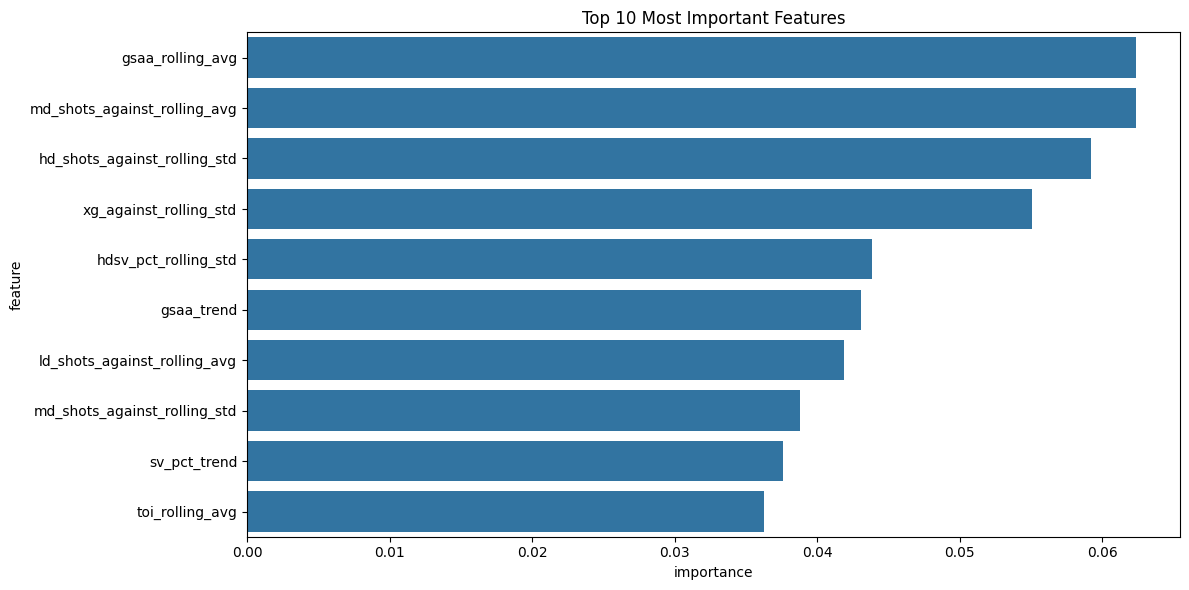

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'feature': list(metrics['feature_importance'].keys()),
    'importance': list(metrics['feature_importance'].values())
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

Original data length: 21
Predictions length: 21
X_scaled shape: (21, 28)


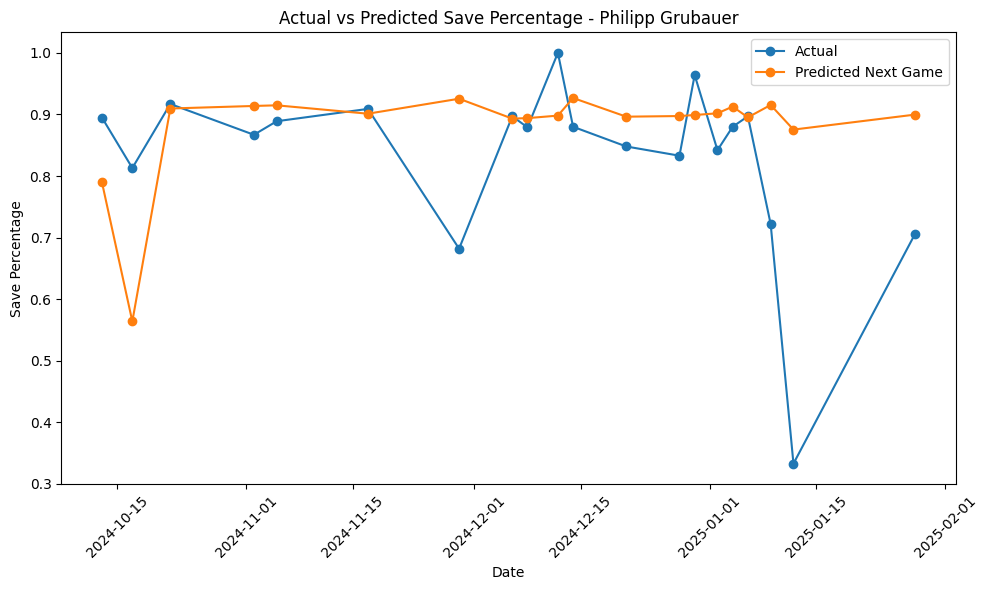


Predicted save percentage for Philipp Grubauer's next game: 0.837


In [ ]:
# Plot actual vs predicted values for a specific goalie
goalie_name = 'Philipp Grubauer'
goalie_data = processed_data[processed_data['player'] == goalie_name].copy()  # Make a copy
X, processed_df = prepare_features(goalie_data)
X_scaled = scaler.transform(X)
predictions = model.predict(X_scaled)

# Print dimensions to debug
print(f"Original data length: {len(goalie_data)}")
print(f"Predictions length: {len(predictions)}")
print(f"X_scaled shape: {X_scaled.shape}")

# Create the plot with aligned data
plt.figure(figsize=(10, 6))
# Use the same date range for both actual and predicted values
dates = goalie_data['date'].iloc[:-1]  # Remove last date
actual_values = goalie_data['sv_pct'].iloc[:-1]  # Remove last actual value

plt.plot(dates, actual_values, label='Actual', marker='o')
plt.plot(dates, predictions[:-1], label='Predicted Next Game', marker='o')
plt.title(f'Actual vs Predicted Save Percentage - {goalie_name}')
plt.xlabel('Date')
plt.ylabel('Save Percentage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the prediction for the next game
print(f"\nPredicted save percentage for {goalie_name}'s next game: {predictions[-1]:.3f}")

In [46]:
performance_scalar

1.0187401996962557

In [47]:
g

NameError: name 'g' is not defined